In [447]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.datasets import make_moons
from isotree import IsolationForest


import sys
sys.path.append('..')

from cfmining.baselines import MAPOCAM
from cfmining.action_set import ActionSet
from cfmining.predictors import MonotoneClassifier
from cfmining.algorithms import MAPOFCEM
from sklearn.neighbors import KernelDensity

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [441]:
seed = 0

In [442]:
np.random.seed(seed)


# generate data on the inferior half of the unit circle
X, y = make_moons(n_samples=200, noise=0.1, random_state=seed)
X = X[y == 1]
X = pd.DataFrame(X, columns=['x1', 'x2'])

# transform data to [0, 1]^2
X = (X - X.min()) / (X.max() - X.min())

In [443]:
kde = KernelDensity(bandwidth=0.1).fit(X.values)

In [444]:
class MyOutlierDetector:
    def __init__(self, kde):
        self.kde = kde
    def predict(self, X):
        pred = self.kde.score_samples(X)
        pred = np.where(pred < -0.5, -1, 1)
        return pred

In [445]:
outlier_detection = MyOutlierDetector(kde)

In [446]:
a = 2
b = 1
c = -1.1

class MyClassifier:
    def __init__(self):
        self.monotone= True
        self.feat_importance    = np.array([a, b])
        self.threshold = 0.5

    def predict_proba(self, x):
        if type(x) == pd.DataFrame:
            x = x.values
        if x.ndim == 1:
            return np.array([x[0] * a + x[1] * b + c, x[0] * a + x[1] * b + c])
        out = np.array([x[:, 0] * a + x[:, 1] * b + c]).T
        # add a column of zeros
        return np.hstack([out, out])
    
    def __call__(self, x):
        return self.predict_proba(x)[:, 1] > self.threshold
    
classifier = MyClassifier()

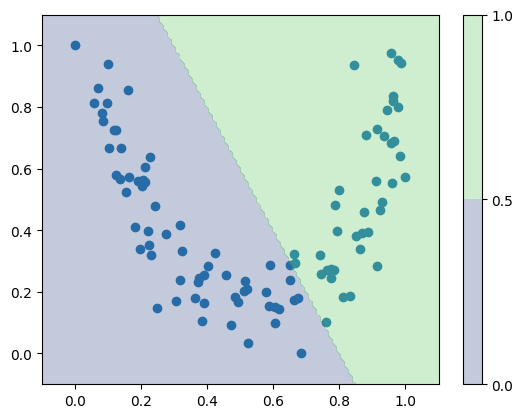

In [434]:
plt.scatter(X['x1'], X['x2'])

# plot the classifier
x1 = np.linspace(-0.1, 1.1, 100)
X1, X2 = np.meshgrid(x1, x1)
Z = classifier(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
plt.contourf(X1, X2, Z, alpha=0.3)

plt.colorbar()

In [435]:
# get closest individual to (2, 0.5)
closest = np.argmin(np.linalg.norm(X.values - [0.1, 1], axis=1))
individual = X.iloc[closest]
individual

x1    0.101712
x2    0.940600
Name: 71, dtype: float64

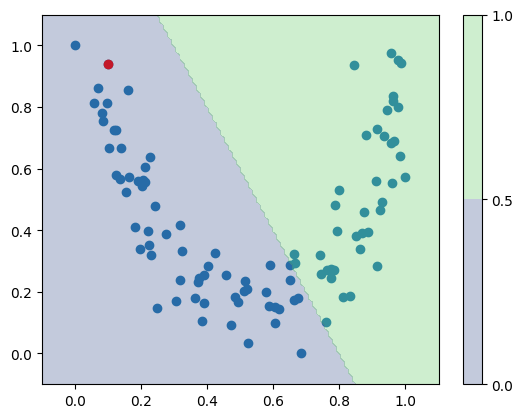

In [436]:
plt.scatter(X['x1'], X['x2'])
plt.scatter(individual['x1'], individual['x2'], color='red')
# plot the classifier
x1 = np.linspace(-0.1, 1.1, 100)
X1, X2 = np.meshgrid(x1, x1)
Z = classifier(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
plt.contourf(X1, X2, Z, alpha=0.3)

plt.colorbar()

In [448]:
classifier_ = MonotoneClassifier(classifier, outlier_detection, X)


action_set = ActionSet(X)
mapofcem = MAPOFCEM(action_set, classifier_, "non_dom", estimate_outlier=False)
mapofcem.fit(individual.values)
mapofcem_solutions = np.array(mapofcem.solutions)


for feat in action_set:
    feat.flip_direction = 1
    feat.update_grid()
    
mapocam = MAPOCAM(action_set, classifier_, criteria = "non_dom", max_changes = 10)
mapocam.fit(individual.values)
mapocam_solutions = np.array(mapocam.solutions)



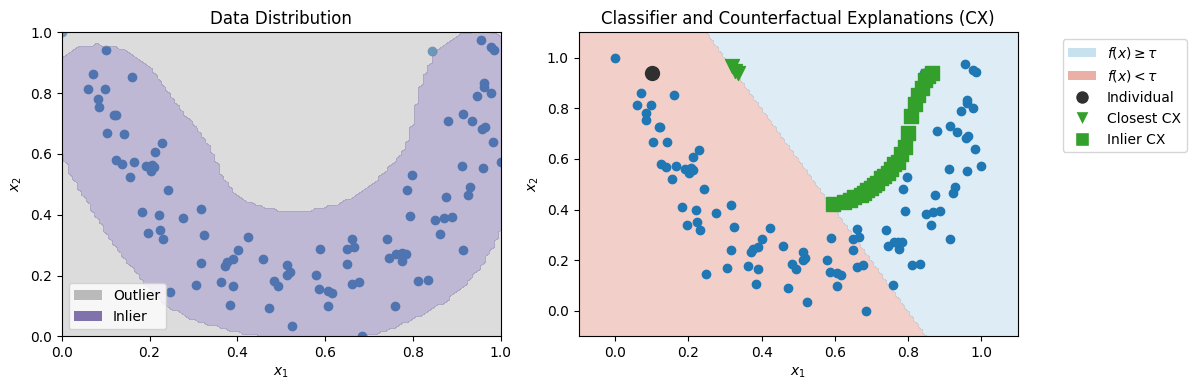

In [452]:
fig, axs = plt.subplots(nrows = 1, ncols =2, figsize = (12, 4))


axs[0].scatter(X['x1'], X['x2'])
x1 = np.linspace(0, 1, 100)
x1, x2 = np.meshgrid(x1, x1)
x1 = x1.flatten()
x2 = x2.flatten()
X_grid = np.vstack([x1, x2]).T
pred = outlier_detection.predict(X_grid)
axs[0].contourf(x1.reshape(100, 100), x2.reshape(100, 100), pred.reshape(100, 100), alpha=0.5, levels=[-1, 0, 1], colors=['#bababa', '#8073ac', 'blue'])
handles = [
    Patch(facecolor='#bababa', label='Outlier'),
    Patch(facecolor='#8073ac', label='Inlier'),
]
axs[0].legend(handles=handles)



# plot the classifier
x1 = np.linspace(-0.1, 1.1, 100)
X1, X2 = np.meshgrid(x1, x1)
Z = classifier(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
axs[1].contourf(X1, X2, Z, alpha=0.3, levels=[0, 0.5, 1], colors=['#d6604d', '#92c5de', '#35978f'])


# plot non_dom solutions
axs[1].scatter(X['x1'], X['x2'])
axs[1].scatter(individual['x1'], individual['x2'], color='#303030', s=100)
axs[1].scatter(mapocam_solutions[:, 0], mapocam_solutions[:, 1], color='#33a02c', marker='v', s = 100)
axs[1].scatter(mapofcem_solutions[:, 0], mapofcem_solutions[:, 1], color='#33a02c', marker = "s", s = 100)






handles = [
    Patch(facecolor='#92c5de', label='$f(x) \geq \\tau$', alpha=0.5),
    Patch(facecolor='#d6604d', label='$f(x) < \\tau$', alpha = 0.5),
    Line2D([0], [0], markerfacecolor='#303030', marker = 'o', label='Individual', color='w', markersize=10),
    Line2D([0], [0], color='w', marker = 'v', label='Closest CX', markerfacecolor='#33a02c', markersize=10),
    Line2D([0], [0], color='w', marker = 's', label='Inlier CX',  markerfacecolor='#33a02c', markersize=10),
    
]
axs[1].legend(handles=handles, loc='upper right', bbox_to_anchor=(1.4, 1))


for i in range(2):
    axs[i].set_xlabel("$x_1$")
    axs[i].set_ylabel("$x_2$")

axs[0].set_title("Data Distribution")
axs[1].set_title("Classifier and Counterfactual Explanations (CX)")

#axs[1].set_xlim(0.2, 0.45)
#axs[1].set_ylim(0.8, 1.0)
plt.tight_layout()
#plt.savefig("../figures/toy_example.pdf")
